In [70]:
from sqlalchemy import create_engine, MetaData, Table, Column, Integer, String, select, Float, DateTime, or_
from sqlalchemy.orm import Session
from sqlalchemy.sql import func
from urllib.parse import quote_plus
from collections import defaultdict
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sqlalchemy import inspect
from scipy import stats
import matplotlib.pyplot as plt
import transformed_data as td
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from bioinfokit.analys import stat
import random
meta = MetaData()
USERNAME = 'qazal'
PASSWORD = '6857'
SERVER = 'localhost'
engine = create_engine(f'mysql+pymysql://{USERNAME}:{PASSWORD}@{SERVER}:3306/crypto' ,echo = False)
conn = engine.connect()
session = Session(engine)

ModuleNotFoundError: No module named 'transformed_data'

In [ ]:
cryptopricetimes = Table(
    'cryptopricetimes', 
    meta,
    autoload_with=engine
)
cryptocurrencies = Table(
    'cryptocurrencies', 
    meta,
    autoload_with=engine
)
cryptodailyhistory = Table(
    'cryptodailyhistory', 
    meta,
    autoload_with=engine
)
cryptohistoricalprices = Table(
    'cryptohistoricalprices', 
    meta,
    autoload_with=engine
)
cryptopricetypes = Table(
    'cryptopricetypes', 
    meta,
    autoload_with=engine
)
cryptotags = Table(
    'cryptotags', 
    meta,
    autoload_with=engine
)
dates = Table(
    'dates', 
    meta,
    autoload_with=engine
)
tags = Table(
    'tags', 
    meta,
    autoload_with=engine
)

Q1:

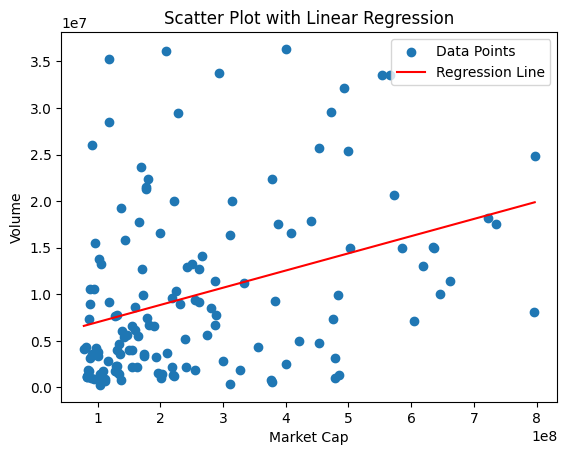

In [ ]:
ds = select(cryptodailyhistory.c.crypto_id, cryptodailyhistory.c.date_id,cryptodailyhistory.c.market_cap, cryptodailyhistory.c.volume).select_from(cryptodailyhistory)
conn = engine.connect()
result = conn.execute(ds)
dfs = pd.DataFrame(result.fetchall(), columns=["crypto_id","date_id","market_cap", "volume"])
dfs = dfs[dfs['date_id'] == 1]
dfs = dfs[dfs['volume'] <= 40000000]
dfs = dfs[dfs['market_cap'] <= 1000000000]

X = dfs['market_cap'].values.reshape(-1, 1)
y = dfs['volume'].values

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

plt.scatter(X, y, label='Data Points')
plt.plot(X, y_pred, color='red', label='Regression Line')
plt.xlabel('Market Cap')
plt.ylabel('Volume')
plt.legend()
plt.title('Scatter Plot with Linear Regression')
plt.show()

<div style="direction: rtl; text-align: right;">
    در این نمودار مشاهده میکنیم که کوین هایی که مارکت کپ بیشتری دارند، حجم معاملاتی بیشتری نیز دارند که برای این مفهوم با استفاده از رگرسیون مشاهده میکنیم که این دو تقریبا رابطه ای خطی دارند
<div/>

Q2:

In [ ]:
d = select(cryptopricetimes.c.crypto_price_time_id, cryptopricetimes.c.crypto_daily_id, cryptopricetimes.c.crypto_price_type_id).select_from(cryptopricetimes)
conn = engine.connect()
result = conn.execute(d)
df = pd.DataFrame(result.fetchall(), columns=["crypto_price_time_id", "crypto_daily_id", "crypto_price_type_id"])
d1 = select(cryptohistoricalprices.c.crypto_price_time_id, cryptohistoricalprices.c.crypto_price).select_from(cryptohistoricalprices)
conn = engine.connect()
result = conn.execute(d1)
dfp = pd.DataFrame(result.fetchall(), columns=["crypto_price_time_id", "crypto_price"])
d2 = select(cryptopricetypes.c.crypto_price_type_id, cryptopricetypes.c.crypto_price_type_name).select_from(cryptopricetypes)
conn = engine.connect()
result = conn.execute(d2)
dft = pd.DataFrame(result.fetchall(), columns=["crypto_price_type_id", "crypto_price_type_name"])
d3 = select(cryptodailyhistory.c.crypto_daily_id, cryptodailyhistory.c.crypto_id).select_from(cryptodailyhistory)
conn = engine.connect()
result = conn.execute(d3)
dfc = pd.DataFrame(result.fetchall(), columns=["crypto_daily_id", "crypto_id"])
d4 = select(cryptocurrencies.c.crypto_id, cryptocurrencies.c.crypto_name).select_from(cryptocurrencies)
conn = engine.connect()
result = conn.execute(d4)
dfn = pd.DataFrame(result.fetchall(), columns=["crypto_id", "crypto_name"])
result = pd.merge(df, dfp, on='crypto_price_time_id', how='inner')
result = pd.merge(result, dft, on='crypto_price_type_id', how='inner')
result = pd.merge(result, dfc, on='crypto_daily_id', how='inner')
result = pd.merge(result, dfn, on='crypto_id', how='inner')
result = result.sort_values(by=['crypto_daily_id', 'crypto_price_type_id'])
O = 0
C = 0
price_change_counts = {}
for index , row in result.iterrows():
    if (row['crypto_price_type_name'] == "Open" or row['crypto_price_type_name'] == "Close"):
        if (row['crypto_price_type_name'] == "Open"):
            O = row['crypto_price'] 
        else:
            C = row['crypto_price'] 
            symbol = str(row['crypto_id'])
            change = C - O
            if symbol in price_change_counts:
                price_change_counts[symbol].append(change)
            else:
                price_change_counts[symbol] = [change]
                
changes = np.zeros((200, 200))
for i in range (0, 200):
    for j in range (i + 1, 200):
        c1 = price_change_counts[str(i + 1)]
        c2 = price_change_counts[str(j + 1)]
        for k in range(min(len(c1) , len(c2))):
            if ((c1[k] < 0 and c2[k] < 0) or (c1[k] > 0 and c2[k] > 0)):
                changes[i][j] += 1
changes

k = 30
flat_indices = np.argpartition(changes.flatten(), -k)[-k:]

row_indices, col_indices = np.unravel_index(flat_indices, changes.shape)

top_30_max_values = changes[row_indices, col_indices]

sorted_indices = np.argsort(top_30_max_values)[::-1]
sorted_top_30_max_values = top_30_max_values[sorted_indices]
sorted_row_indices = row_indices[sorted_indices]
sorted_col_indices = col_indices[sorted_indices]
for i in range(k):
    C1 = dfn[dfn['crypto_id'] == sorted_row_indices[i] + 1]['crypto_name'].to_string(index=False)
    C2 = dfn[dfn['crypto_id'] == sorted_col_indices[i] + 1]['crypto_name'].to_string(index=False)
    if C1 <= C2:
        print(sorted_top_30_max_values[i], C1, " and ", C2)
    else:
        print(sorted_top_30_max_values[i], C2, " and ", C1)


351.0 Bitcoin  and  Wrapped Bitcoin
322.0 Decentraland  and  The Sandbox
317.0 Enjin Coin  and  The Sandbox
317.0 Ethereum  and  Gnosis
314.0 Ethereum  and  Wrapped Bitcoin
311.0 Decentraland  and  Oasis Network
310.0 Axie Infinity  and  The Sandbox
310.0 Axie Infinity  and  Decentraland
309.0 Bitcoin  and  Ethereum
308.0 Ankr  and  Zilliqa
308.0 BNB  and  PancakeSwap
308.0 ICON  and  The Sandbox
308.0 Decentraland  and  VeChain
307.0 Axie Infinity  and  Oasis Network
307.0 Oasis Network  and  The Sandbox
307.0 ICON  and  IOST
307.0 Decentraland  and  Enjin Coin
306.0 Cardano  and  Ethereum Classic
306.0 0x Protocol  and  VeChain
306.0 ICON  and  Threshold
306.0 0x Protocol  and  ICON
306.0 Cardano  and  Harmony
306.0 Basic Attention Token  and  Ontology
306.0 Ankr  and  ICON
306.0 1inch Network  and  Oasis Network
305.0 Avalanche  and  Holo
305.0 Basic Attention Token  and  Oasis Network
304.0 Tezos  and  The Sandbox
304.0 Basic Attention Token  and  Tezos
304.0 Tezos  and  VeChain


In [ ]:
cryptocurrencies_df = td.TransformedData.cryptocurrencies_df.copy()
crypto_tag_df = td.TransformedData.crypto_tag_df.copy()
tags_df = td.TransformedData.tags_df.copy()
crypto_daily_history_df = td.TransformedData.crypto_daily_history_df.copy()

In [ ]:
t1 = pd.merge(cryptocurrencies_df, crypto_tag_df, on='crypto_id', how='inner')
t2 = pd.merge(t1, tags_df, on='tag_id', how='inner')
t3 = t2.loc[t2.tag_name == 'Mineable']
t4 = pd.merge(t3, crypto_daily_history_df, on='crypto_id', how='inner')
minable_coins_volumes = t4.loc[:, ['volume']]
minable_coins_volumes

##### Descriptive Statistics, Q 3:
    Plot the 24h daily volume distribution of 'Mineable' cryptocurrencies.

In [ ]:
# low volumes
low_volumes = minable_coins_volumes.loc[minable_coins_volumes.volume < 2e9, 'volume'].values.tolist()
low_volumes = [0] + low_volumes + [2e9]

# middle volumes
middle_volumes = minable_coins_volumes.loc[(minable_coins_volumes.volume <= 60e9) & (minable_coins_volumes.volume >= 2e9), 'volume'].values.tolist()
middle_volumes = [0] + middle_volumes + [60e9]

# high volumes
high_volumes = minable_coins_volumes.loc[minable_coins_volumes.volume > 60e9, 'volume'].values.tolist()
high_volumes = high_volumes

In [ ]:
sns.histplot(low_volumes, bins=20, alpha=0.5, kde=True)
plt.title('Low volumes')
plt.xticks([0, 0.4e9, 0.8e9, 1.2e9, 1.6e9, 2e9], ['0', '0.4B', '0.8B', '1.2B', '1.6B', '2B'])

In [ ]:
sns.histplot(middle_volumes, bins=10, alpha=0.5, kde=True)
plt.xticks([0, 10e9, 20e9, 30e9, 40e9, 50e9, 60e9], ['0', '10B', '20B', '30B', '40B', '50B', '60B'])
plt.title('Middle volumes')

In [ ]:
sns.histplot(high_volumes, bins=10, alpha=0.5)
plt.xticks([60e9, 70e9, 80e9, 90e9, 100e9, 110e9, 120e9], ['60B', '70B', '80B', '90B', '100B', '110B', '120B'])
plt.title('High volumes')

In [ ]:
temp_table = pd.merge(cryptocurrencies_df, crypto_daily_history_df, on='crypto_id', how='inner')
cryptoname_volume = temp_table.loc[:, ['crypto_name', 'volume']]
cryptoname_volume

Q4:

Text(0.5, 1.0, 'Correlation Matrix')

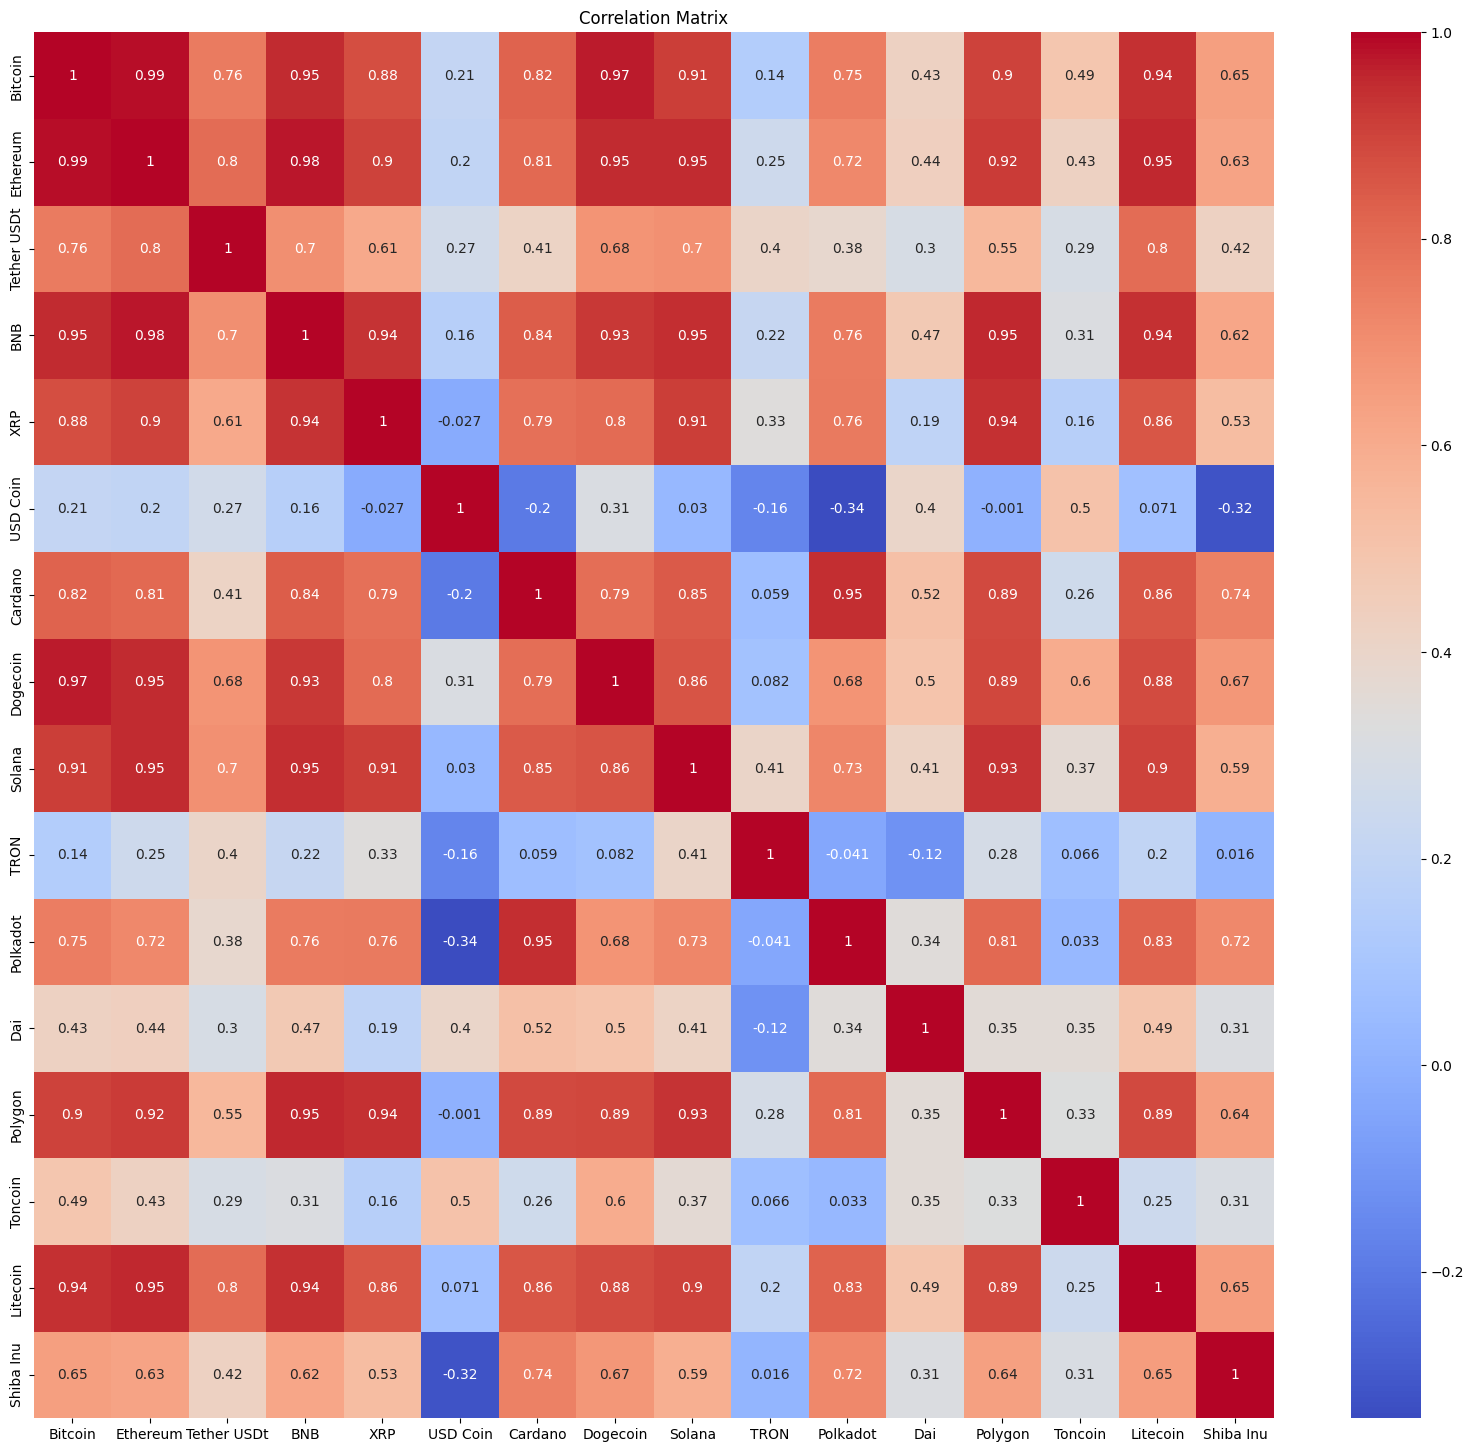

In [ ]:
dm = select(cryptodailyhistory.c.crypto_daily_id, cryptodailyhistory.c.crypto_id, cryptodailyhistory.c.date_id,cryptodailyhistory.c.market_cap).select_from(cryptodailyhistory)
conn = engine.connect()
result = conn.execute(dm)
dfm = pd.DataFrame(result.fetchall(), columns=["crypto_daily_id", "crypto_id","date_id","market_cap"])
coin_names = ['Bitcoin', 'Ethereum', 'Tether USDt', 'BNB', 'XRP', 'USD Coin', 'Cardano', 'Dogecoin', 'Solana', 'TRON',
            'Polkadot', 'Dai', 'Polygon', 'Toncoin', 'Litecoin', 'Shiba Inu']
data_rows = []
for i in range(1, 11):
    x = dfm[dfm['date_id'] == i]
    x = x.sort_values(by=['market_cap'], ascending=False)
    top_16 = x.head(16)
    res = pd.merge(top_16, df, on='crypto_daily_id', how='inner')
    res = pd.merge(res, dfp, on='crypto_price_time_id', how='inner')
    res = res[(res['crypto_price_type_id'] == 1) | (res['crypto_price_type_id'] == 2)]
    res
    t = 0
    pl = np.zeros(16)
    for index , row in res.iterrows():
        if (index % 2 == 0):
            t = t - row['crypto_price']
        else:
            t = t + row['crypto_price']
            pl[row['crypto_id'] - 1] = t
            t = 0
    data_rows.append(dict(zip(coin_names, pl)))
pll = pd.DataFrame(data_rows)
fig2, ax2 = plt.subplots(figsize=(20, 18))
corr = pll.corr()
sns.heatmap(corr, annot=True, xticklabels=corr.columns.values, yticklabels=corr.columns.values, cmap='coolwarm')
ax2.set_title('Correlation Matrix')

<div style="direction: rtl; text-align: right;">
همانطور که از ماتریس همبستگی مشخص است، ارز هایی که در تعداد روز های بیشتری تغییرات قیمت همسو داشته اند، همبستگی بیشتری دارند
<div/>

Q5:

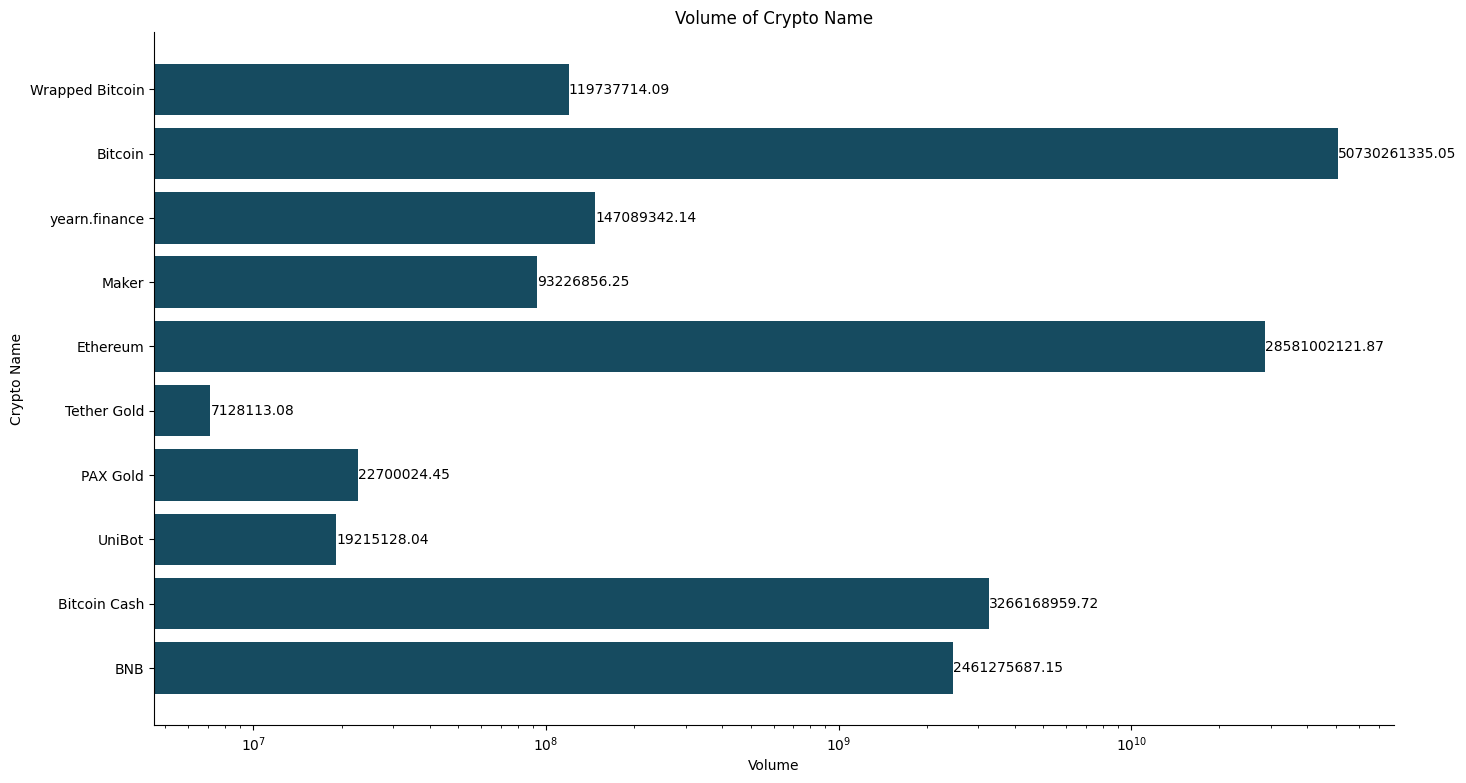

In [ ]:
res1 = session.query(
    cryptohistoricalprices.c.crypto_price,
    cryptopricetimes.c.crypto_daily_id,
    cryptopricetimes.c.crypto_price_type_id,
    dates.c.date,
    cryptocurrencies.c.crypto_name,
    cryptodailyhistory.c.volume
).filter(
    cryptohistoricalprices.c.crypto_price_time_id == cryptopricetimes.c.crypto_price_time_id
).filter(
    cryptopricetimes.c.crypto_daily_id == cryptodailyhistory.c.crypto_daily_id,
    cryptodailyhistory.c.crypto_id == cryptocurrencies.c.crypto_id,
    dates.c.date_id == cryptodailyhistory.c.date_id
).filter(
    or_(
        cryptopricetimes.c.crypto_price_type_id == 1,
        cryptopricetimes.c.crypto_price_type_id == 2
    )
).all()

data_dict = defaultdict(lambda: {'price_type_1': None, 'price_type_2': None, 'volume': None, 'crypto_name': None})

for row in res1:
    crypto_price, daily_id, price_type_id, date, crypto_name, volume = row
    if price_type_id == 1:
        data_dict[daily_id]['price_type_1'] = crypto_price
    elif price_type_id == 2:
        data_dict[daily_id]['price_type_2'] = crypto_price
    data_dict[daily_id]['volume'] = volume
    data_dict[daily_id]['crypto_name'] = crypto_name

data_dict = {k: v for k, v in data_dict.items() if v.get('price_type_1') is not None and v.get('price_type_2') is not None}

for daily_id, data in data_dict.items():
    data['price_difference'] = data['price_type_2'] - data['price_type_1']

entries = list(data_dict.values())
sorted_entries = sorted(entries, key=lambda x: x['price_difference'], reverse=True)
max_price_diff_dict = {}

for entry in sorted_entries:
    crypto_name = entry["crypto_name"]
    price_diff = entry["price_difference"]
    volume = entry["volume"]
    if crypto_name not in max_price_diff_dict or price_diff > max_price_diff_dict[crypto_name]["price_difference"]:
        max_price_diff_dict[crypto_name] = entry

top_10_max_price_diff = sorted(max_price_diff_dict.values(), key=lambda x: x["price_difference"], reverse=True)[:10]

for entry in top_10_max_price_diff:
    entry["volume"] = max_price_diff_dict[entry["crypto_name"]]["volume"]

crypto_names = [entry['crypto_name'] for entry in top_10_max_price_diff]
volumes = [float(entry['volume']) for entry in top_10_max_price_diff]

fig, ax = plt.subplots(figsize=(16, 9))

ax.barh(crypto_names, volumes, color='#164B60')

for i, v in enumerate(volumes):
    ax.text(v + 3, i, f'{v:.2f}', color='black', va='center')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.invert_yaxis()

plt.xlabel('Volume')
plt.ylabel('Crypto Name')
plt.title('Volume of Crypto Name')
plt.xscale('log')
plt.show()

Estimate

In [ ]:
random_crypto_ids = session.query(cryptodailyhistory.c.crypto_id) \
    .distinct() \
    .order_by(func.random()) \
    .limit(40) \
    .all()
crypto_data_with_avg_volume = []

for crypto_id in random_crypto_ids:
    crypto_data = session.query(cryptodailyhistory.c.volume) \
        .filter(cryptodailyhistory.c.crypto_id == crypto_id[0]) \
        .all()

    volumes = [result[0] for result in crypto_data]
    avg_volume = sum(volumes) / len(volumes)
    crypto_data_with_avg_volume.append((crypto_id, avg_volume))

avg_volumes = [float(data[1]) for data in crypto_data_with_avg_volume]
mean_avg_volumes = np.mean(avg_volumes)
t_multiplier = stats.t.ppf((1 + 0.98) / 2, df=40-1)
margin_of_error = t_multiplier * (mean_avg_volumes / np.sqrt(40))
lower_bound = mean_avg_volumes - margin_of_error
upper_bound = mean_avg_volumes + margin_of_error
lower_bound,upper_bound


(561714214.7183013, 1260729137.9706135)

Hypothesis Test
Q1:

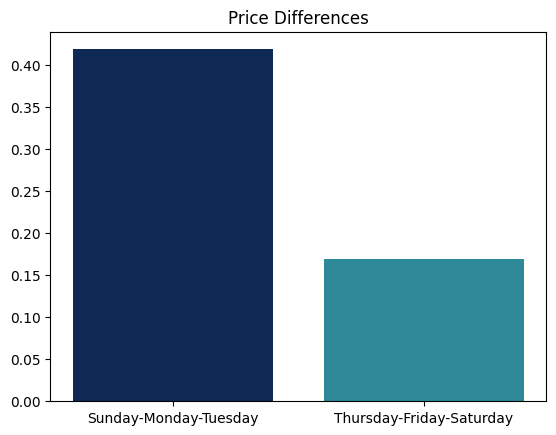

In [ ]:
res2 =session.query(
    cryptohistoricalprices.c.crypto_price,
    cryptopricetimes.c.crypto_daily_id,
    cryptopricetimes.c.crypto_price_type_id,
    dates.c.date,
    dates.c.date_id,
).filter(
    cryptohistoricalprices.c.crypto_price_time_id == cryptopricetimes.c.crypto_price_time_id
).filter(
    cryptopricetimes.c.crypto_daily_id == cryptodailyhistory.c.crypto_daily_id,
    cryptodailyhistory.c.crypto_id == cryptocurrencies.c.crypto_id,
    dates.c.date_id == cryptodailyhistory.c.date_id
).filter(
    or_(
        cryptopricetimes.c.crypto_price_type_id == 1,
        cryptopricetimes.c.crypto_price_type_id == 2
    )
).all()

day_names_dict = {}

for result in res2:
    day_of_week = result[3].weekday()
    days_of_week_names = ["Monday", "Tuesday", "Wednesday",'Thursday','Friday','Saturday', "Sunday"]
    day_name = days_of_week_names[day_of_week]
    day_names_dict[result[4]] = day_name

res2 = [(result[0], result[1], result[2], result[3], result[4], day_names_dict[result[4]]) for result in res2]
data_dict = {}

for row in res2:
    crypto_price, daily_id, price_type_id, date, date_id, day_name = row
    if daily_id not in data_dict:
        data_dict[daily_id] = {'price_type_1': None, 'price_type_2': None, 'day_name': day_name}
    if price_type_id == 1:
        data_dict[daily_id]['price_type_1'] = crypto_price
    elif price_type_id == 2:
        data_dict[daily_id]['price_type_2'] = crypto_price

for daily_id, data in data_dict.items():
    price_type_1 = data['price_type_1']
    price_type_2 = data['price_type_2']
    if price_type_1 is not None and price_type_2 is not None:
        price_difference = price_type_2 - price_type_1
        data['price_difference'] = price_difference

data_dict = {k: v for k, v in data_dict.items()}

price_diffs_weekdays = [data['price_difference'] for data in data_dict.values() if data.get('day_name') in ['Tuesday', 'Monday', 'Sunday'] and 'price_difference' in data]
average_price_diff_weekdays = sum(price_diffs_weekdays) / len(price_diffs_weekdays) if price_diffs_weekdays else None


price_diffs_weekends = [data['price_difference'] for data in data_dict.values() if data.get('day_name') in ['Thursday','Friday','Saturday'] and 'price_difference' in data]
average_price_diff_weekends = sum(price_diffs_weekends) / len(price_diffs_weekends) if price_diffs_weekends else None

labels = ['Sunday-Monday-Tuesday','Thursday-Friday-Saturday']
values = [average_price_diff_weekdays, average_price_diff_weekends]
colors = ['#0E2954','#2E8A99']

fig, ax = plt.subplots()
ax.bar(labels, values, color=colors)

plt.title('Price Differences')
plt.show()

<div style="direction: rtl; text-align: right;">
  
  بله تفاوت فاحشی میان دو انتخاب ممکن برای روزهای کاری وجود دارد.
  
  با توجه به میانگین تغییر قیمت رمزارزها در دو گروه زمانی مورد بحث، انتخاب روزهای چهارشنبه تا شنبه به عنوان روزهای کاری به نظر می‌رسد مناسب باشد.
    
  
   - میانگین تغییر قیمت در روزهای "یکشنبه، دوشنبه، سه‌شنبه" بیشتر است که نشان دهنده فعالیت بیشتر در این روزها در بازار رمزارزها می‌باشد. 
   انتخاب روزهای "پنجشنبه، جمعه، شنبه" به عنوان روزهای آخر هفته، معمولاً باعث می‌شود که فعالیت بازار کمتر باشد و تغییرات قیمت نیز کاهش یابد.

<div/>

Q 7:

In [ ]:
# Perform t-test

# H-null: The average daily trading volume of 'Bitcoin', 'Ethereum' and 'Tether USDt' is not much higher than the average daily trading volume of other cryptocurrencies."
# H-alt: The average daily trading volume of 'Bitcoin', 'Ethereum' and 'Tether USDt' is much higher than the average daily trading volume of other cryptocurrencies."

# Define Group 1 ('Bitcoin,' 'Ethereum,' and 'Tether USDt')
group1 = ['Bitcoin', 'Ethereum', 'Tether USDt']

# Filter data for Group 1
group1_data = cryptoname_volume.loc[cryptoname_volume['crypto_name'].isin(group1), 'volume']

# Filter data for Group 2 (others)
group2_data = cryptoname_volume.loc[~cryptoname_volume['volume'].isin(group1), 'volume']

# Perform independent t-test
t_statistic, p_value = stats.ttest_ind(group1_data, group2_data, equal_var=False)

# Define significance level
alpha = 0.01

# Interpret the results
if p_value < alpha:
    print("p-value (={}) is far less than alpha (={}).".format(p_value, alpha))
    print("Reject the null hypothesis.")
    print("The average daily trading volume of 'Bitcoin', 'Ethereum' and 'Tether USDt' is significantly much higher than the average daily trading volume of other cryptocurrencies.")
else:
    print("p-value (={}) is graater than alpha (={}).".format(p_value, alpha))
    print("Fail to reject the null hypothesis.")
    print("No significant difference in average daily trading volume of 'Bitcoin', 'Ethereum' and 'Tether USDt' and average daily trading volume of other cryptocurrencies.")


##### Conlusion:
    p-value (=4.960064018232957e-230) is far less than alpha (=0.01) so,
    The average daily trading volume of 'Bitcoin', 'Ethereum' and 'Tether USDt' is significantly much higher than the average daily trading volume of other cryptocurrencies.

In [ ]:
import warnings
warnings.filterwarnings("ignore")


# Perform one-way ANOVA

# H-null: All groups have the same mean daily trading volume
# H-alt: At least one group has a different mean daily trading volume

model = sm.formula.ols('volume ~ crypto_name', data=cryptoname_volume).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Define significance level
alpha = 0.01

# Interpret the results
if anova_table['PR(>F)'][0] < alpha:
    print("Reject the null hypothesis.")
    print("At least one group has a different mean daily trading volume.")
    
    # Perform multiple pairwise comparison (Tukey's HSD)
    print("*******************************************************")
    print("Performing multiple pairwise comparison (Tukey's HSD): ")
    res = stat()
    res.tukey_hsd(df=cryptoname_volume, res_var='volume', xfac_var='crypto_name', anova_model='volume ~ crypto_name')
    pairwise_talbe = res.tukey_summary.loc[
        (res.tukey_summary.group1 == 'Bitcoin') | 
        (res.tukey_summary.group1 == 'Ethereum') | 
        (res.tukey_summary.group1 == 'Tether USDt'),
        ['group1', 'group2', 'p-value']
    ]
    
    pairwise_talbe['reject'] = pairwise_talbe.loc[:, 'p-value'] < alpha
    print(pairwise_talbe)
    
    if pairwise_talbe['reject'].all():    
        print(
            "Conclusion:", 
                    "1. The average daily trading volume of 'Bitcoin' is significantly far higher than the average daily trading volume of any other cryptocurrencies.",
                    "2. The average daily trading volume of 'Ethereum' is significantly far higher than the average daily trading volume of any other cryptocurrencies.", 
                    "3. The average daily trading volume of 'Tether USDt' is significantly far higher than the average daily trading volume of any other cryptocurrencies.",
                    sep="\n"
        )
    
else:
    print("Fail to reject the null hypothesis.")
    print("No significant difference in average daily trading volume among groups.")


##### Conlusion:
1. The average daily trading volume of 'Bitcoin' is significantly far higher than the average daily trading volume of any other cryptocurrencies.

2. The average daily trading volume of 'Ethereum' is significantly far higher than the average daily trading volume of any other cryptocurrencies.

3. The average daily trading volume of 'Tether USDt' is significantly far higher than the average daily trading volume of any other cryptocurrencies.